# Dataset

## download data

In [1]:
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8', 
           'train.idx': 'dcf7318b2602c06428b9988470c731621716c393', 
           'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in dataset.items():
    gluon.utils.download(root_url + k, data_dir + k, sha1_hash = v)

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


## read dataset

In [2]:
from mxnet import image
from mxnet import nd

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size = batch_size, 
        data_shape = (3, data_shape, data_shape), 
        path_imgrec = data_dir + 'train.rec', 
        path_imgidx = data_dir + 'train.idx', 
        shuffle = True, 
        mean = True, 
        rand_crop = 1, 
        min_object_covered = 0.95, 
        max_attempts = 200)
    val_iter = image.ImageDetIter(
        batch_size = batch_size, 
        data_shape = (3, data_shape, data_shape), 
        path_imgrec = data_dir + 'val.rec', 
        shuffle = False, 
        mean = True)
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

In [3]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


In [4]:
# 1st batch 32 x 3 x 256 x256
batch.data[0][0]


[[[  77.31999969   77.31999969   77.31999969 ...,   44.31999969
     43.31999969   40.31999969]
  [  78.31999969   77.31999969   77.31999969 ...,   41.31999969
     40.31999969   36.31999969]
  [  76.31999969   77.31999969   77.31999969 ...,   39.31999969
     37.31999969   33.31999969]
  ..., 
  [ 106.31999969  107.31999969  106.31999969 ...,   26.31999969
    -70.68000031  -63.68000031]
  [ 107.31999969  105.31999969  104.31999969 ...,   35.31999969
    -69.68000031  -53.68000031]
  [ 106.31999969  106.31999969  105.31999969 ...,   32.31999969
    -52.68000031  -56.68000031]]

 [[  65.72000122   65.72000122   65.72000122 ...,   35.72000122
     34.72000122   31.72000122]
  [  66.72000122   65.72000122   65.72000122 ...,   32.72000122
     31.72000122   27.72000122]
  [  65.72000122   65.72000122   65.72000122 ...,   30.72000122
     28.72000122   25.72000122]
  ..., 
  [ 110.72000122  109.72000122  108.72000122 ...,    7.72000122
    -80.27999878  -64.27999878]
  [ 111.72000122  109

## show data

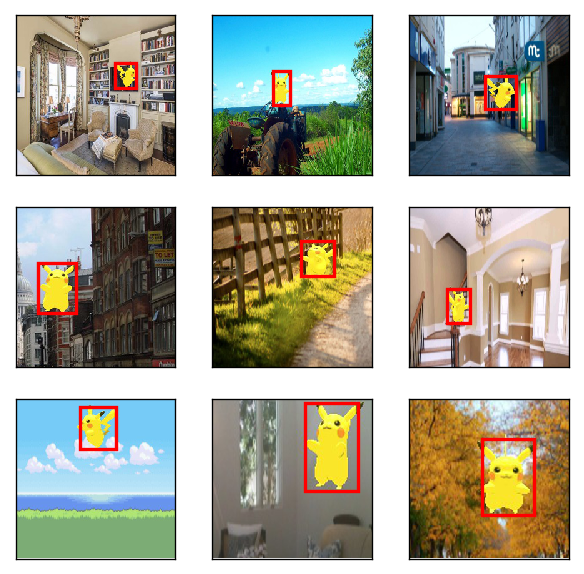

In [5]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth = 3):
    '''convert an anchor box to a matplotlib rectangle'''
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
        fill = False, edgecolor = color, linewidth = linewidth)

_, figs = plt.subplots(3, 3, figsize = (6, 6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3 * i + j], batch.label[0][3 * i + j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0, 255).asnumpy() / 255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels: # label store the retio of axis
            rect = box_to_rect(label[1:5] * data_shape, 'red', 2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

# SSD Model

## anchor box

In [6]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

# shape: batch x channel x height x width
n = 40
# a n x n x 3 rgb image
x = nd.random.uniform(shape = (1, 3, n, n))

y = MultiBoxPrior(x, sizes = [0.5, .25, .1], ratios = [1, 2, .5])
print(y.shape)
# n x n x num_anchor-box x axis(up-left and down-right)
# one img(nxn pixels) total has n x n x num_anchor-box anchor-box 
boxes = y.reshape((n, n, -1, 4)) # -1 means auto calculate
print(boxes.shape)  # 40 x 40 x 5 = 8000 anchor box
# The first anchor box center on (20, 20)
# its format is (x_min, y_min, x_max, y_max)
boxes[20, 20, 0, :] # the (20, 20) pixel

(1, 8000, 4)
(40, 40, 5, 4)



[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>


[[ 0.26249999  0.26249999  0.76249999  0.76249999]
 [ 0.38749999  0.38749999  0.63749999  0.63749999]
 [ 0.46249998  0.46249998  0.5625      0.5625    ]
 [ 0.1589466   0.33572328  0.86605334  0.6892767 ]
 [ 0.33572328  0.1589466   0.6892767   0.86605334]]
<NDArray 5x4 @cpu(0)>


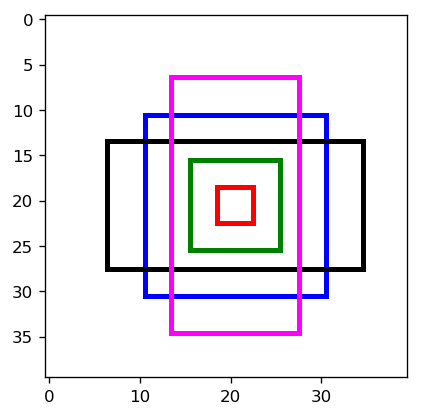

In [7]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
print(anchors)
for i in range(anchors.shape[0]): # 0 1 2 3 4
    # location axis is ratios, so need to by size of image
    plt.gca().add_patch(box_to_rect(anchors[i, :] * n, colors[i]))
plt.show()

## predict object classes

In [8]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    '''return a layer to predict classes'''
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding = 1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2, 55, 20, 20)

## predict bounding box

In [9]:
def box_predictor(num_anchors):
    '''return a layer to predict delta locations'''
    return nn.Conv2D(num_anchors * 4, 3, padding = 1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

## halve module 

In [10]:
def down_sample(num_filters):
    '''stack two Conv_BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size'''
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides = 1, padding = 1))
        out.add(nn.BatchNorm(in_channels = num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
y = blk(x)
y.shape

(2, 10, 10, 10)

## merge predict out from different layers

In [11]:
x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

x: (2, 8, 20, 20)
Class prediction 1: (2, 55, 20, 20)
x: (2, 16, 10, 10)
Class prediction 2: (2, 33, 10, 10)


In [12]:
def flatten_prediction(pred):
    return pred.transpose(axes = (0, 2, 3, 1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim = 1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1:', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2:', flat_y2.shape)
y = concat_predictions([flat_y1, flat_y2])
print('Concat class predictions', y.shape)
y = y.reshape(shape = (0, -1, 10 + 1))
y

Flatten class prediction 1: (2, 22000)
Flatten class prediction 2: (2, 3300)
Concat class predictions (2, 25300)



[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
<NDArray 2x2300x11 @cpu(0)>

## body model

In [13]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.random.uniform(shape = (2, 3, 256, 256))
y = bnet(x)
y.shape

(2, 64, 32, 32)

## built a toy SSD model

In [14]:
def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))
    
    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5): # 1(body) + 3(down_sample) + 1(global_pooling)
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))
    
    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

## calculate predict

In [15]:
def toy_ssd_forward(x, model, sizes, ratios, verbose = False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction
    x = body(x)
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes = sizes[i], ratios = ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with', 
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool = True, pool_type = 'max', 
                kernel = (x.shape[2], x.shape[3]))
    # concat data
    return (concat_predictions(anchors), 
            concat_predictions(class_preds), 
            concat_predictions(box_preds))

## complete model

In [16]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose = False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2, .272], [.37, .447], [.54, .619], 
                      [.71, .79], [.88, .961]]
        self.ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1 # 2 + 3 -1 = 4
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)
    
    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios, 
            verbose = self.verbose)
        # it is better to have class predictions reshaped for softmax computation
        # shape is num_examples x ... x num_class + 1
        class_preds = class_preds.reshape(shape = (0, -1, self.num_classes + 1))
        return anchors, class_preds, box_preds

In [17]:
net = ToySSD(num_classes = 2, verbose = True)
net.initialize()
x = batch.data[0][0 : 1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

Input: (1, 3, 256, 256)
Predict scale 0 (1, 64, 32, 32) with 4096 anchors
Predict scale 1 (1, 128, 16, 16) with 1024 anchors
Predict scale 2 (1, 128, 8, 8) with 256 anchors
Predict scale 3 (1, 128, 4, 4) with 64 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
Output class predictions: (1, 5444, 3)
Output box predictions: (1, 21776)


# Train

## loss function

In [18]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes = (0, 2, 1))
    return MultiBoxTarget(anchors, labels, class_preds)

out = training_targets(anchors, class_preds, batch.label[0][0 : 1])
out

[
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x5444 @cpu(0)>]

In [19]:
out[1].sum() / 4


[ 4.]
<NDArray 1 @cpu(0)>

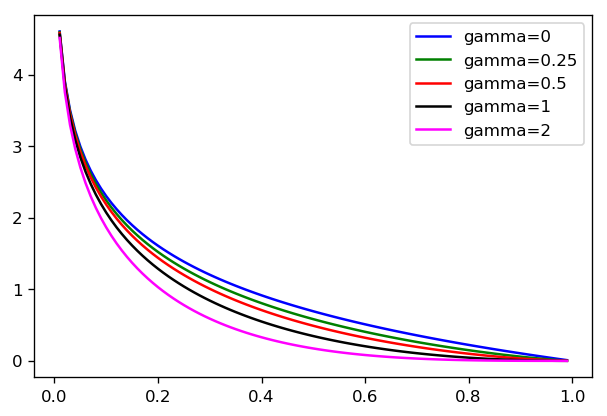

In [20]:
import numpy as np

def focal_loss(gamma, x):
    return - (1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, .01) # 0.01 0.02 0.03 0.04 ... 0.11 0.12 0.13 ... 1
gammas = [0, .25, .5, 1, 2]
for i, g in enumerate(gammas):
    plt.plot(x, focal_loss(g, x), colors[i])
    
plt.legend(['gamma=' + str(g) for g in gammas])
plt.show()

In [21]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis = -1, alpha = 0.25, gamma = 2, batch_axis = 0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis = self._axis, keepdims = True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis = self._batch_axis, exclude = True)
    
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

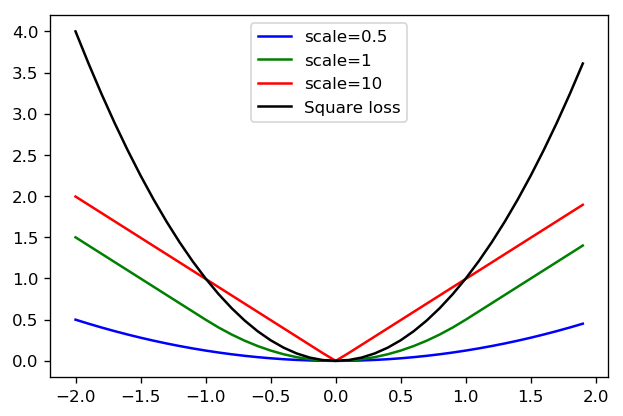

In [22]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2, 0.1)

for i, s in enumerate(scales):
    y = nd.smooth_l1(x, scalar = s)
    plt.plot(x.asnumpy(), y.asnumpy(), color = colors[i])
plt.plot(x.asnumpy(), (x ** 2).asnumpy(), color = colors[len(scales)])
plt.legend(['scale=' + str(s) for s in scales] + ['Square loss'])

In [23]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis = 0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar = 1.0)
        return loss.mean(self._batch_axis, exclude = True)
    
box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

## evaluate metric

In [24]:
from mxnet import metric

cls_metric = metric.Accuracy()
box_metric = metric.MAE()

## initialize model and trainer

In [25]:
from mxnet import init
from mxnet import gpu

ctx = gpu(0)
# the CUDA implementation requres each image has at least 3 labels
# Padd two -1 labels for each instance
train_data.reshape(label_shape = (3, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude = 2), ctx = ctx)
trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

## train model

In [26]:
import time
from mxnet import autograd as ag

for epoch in range(30):
    # reset data iterators and metrics
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with ag.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            # losses
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0, 2, 1))])
        box_metric.update([box_target], [box_preds * box_mask])
    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time() - tic
    ))

Epoch  0, train accuracy 0.94, mae 0.00502, time 9.7 sec
Epoch  1, train accuracy 0.99, mae 0.00375, time 8.6 sec
Epoch  2, train accuracy 0.99, mae 0.00336, time 8.6 sec
Epoch  3, train accuracy 0.99, mae 0.00328, time 8.6 sec
Epoch  4, train accuracy 0.99, mae 0.00310, time 8.7 sec
Epoch  5, train accuracy 1.00, mae 0.00291, time 8.6 sec
Epoch  6, train accuracy 1.00, mae 0.00300, time 8.6 sec
Epoch  7, train accuracy 1.00, mae 0.00284, time 8.7 sec
Epoch  8, train accuracy 1.00, mae 0.00288, time 8.6 sec
Epoch  9, train accuracy 1.00, mae 0.00273, time 8.7 sec
Epoch 10, train accuracy 1.00, mae 0.00276, time 8.6 sec
Epoch 11, train accuracy 1.00, mae 0.00289, time 8.6 sec
Epoch 12, train accuracy 1.00, mae 0.00276, time 8.6 sec
Epoch 13, train accuracy 1.00, mae 0.00272, time 8.6 sec
Epoch 14, train accuracy 1.00, mae 0.00275, time 8.6 sec
Epoch 15, train accuracy 1.00, mae 0.00273, time 8.6 sec
Epoch 16, train accuracy 1.00, mae 0.00274, time 8.6 sec
Epoch 17, train accuracy 1.00, 

# Predict

In [27]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height x width
    return data.transpose((2, 0, 1)).expand_dims(axis = 0), im

In [28]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0, 2, 1)), mode = 'channel')
    
    return MultiBoxDetection(cls_probs, box_preds, anchors, 
                             force_suppress = True, clip = False)

In [29]:
x, im = process_image('../img/pikachu.jpg')
out = predict(x)
out.shape

(1, 5444, 6)

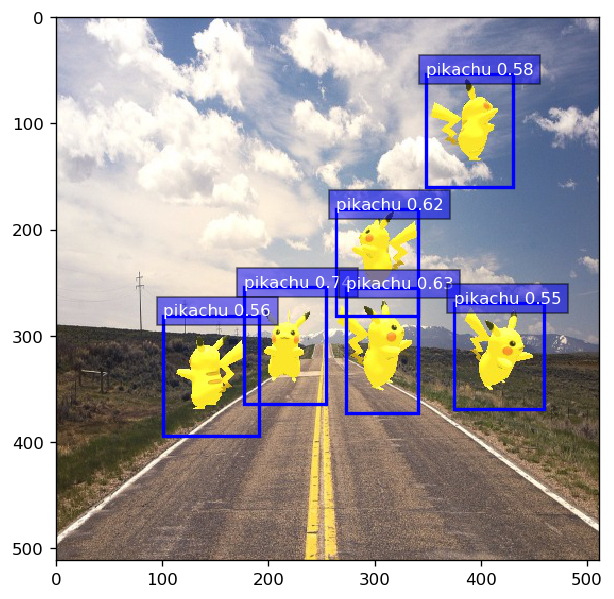

In [30]:
mpl.rcParams['figure.figsize'] = (6, 6)

def display(im, out, threshold = 0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id % len(colors)]
        box = row[2:6] * np.array([im.shape[0], im.shape[1]] * 2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
        
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score), 
                       bbox = dict(facecolor = color, alpha = 0.5), 
                       fontsize = 10, color = 'white')
    plt.show()
    
display(im, out[0], threshold = 0.5)